# Notebook 1: Obtain, Clean & Inspect Data. Promising findings.

The aim here is to get one day's worth of data and understand its structure, how to process it and some of its underlying behaviour. Once understood, we can apply this in later steps to a greater range of dates for further work.

## 1. Obtaining Data

We start by finding what files are available for a particular date by running an `aws s3 ls` on the PDS AWS S3 bucket.
Note the `--no-sign-request` parameter. This means you don't need to have an AWS key or account for this to work.

In [1]:
date = '2018-03-26'

In [2]:
! aws s3 ls s3://deutsche-boerse-xetra-pds/{date}/ --no-sign-request 

2018-04-04 18:07:23        136 2018-03-26_BINS_XETR00.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR01.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR02.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR03.csv
2018-04-04 18:07:23        251 2018-03-26_BINS_XETR04.csv
2018-04-04 18:07:24        136 2018-03-26_BINS_XETR05.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR06.csv
2018-04-04 18:07:24     999016 2018-03-26_BINS_XETR07.csv
2018-04-04 18:07:24     882055 2018-03-26_BINS_XETR08.csv
2018-04-04 18:07:24     861920 2018-03-26_BINS_XETR09.csv
2018-04-04 18:07:24     816397 2018-03-26_BINS_XETR10.csv
2018-04-04 18:07:24     793111 2018-03-26_BINS_XETR11.csv
2018-04-04 18:07:24     848602 2018-03-26_BINS_XETR12.csv
2018-04-04 18:07:24    1094364 2018-03-26_BINS_XETR13.csv
2018-04-04 18:07:24    1260469 2018-03-26_BINS_XETR14.csv
2018-04-04 18:07:24     870234 2018-03-26_BINS_XETR15.csv
2018-04-04 18:07:26        136 2018-03-26_BINS_XETR16.csv
2018-04-04 18:

Download the files into a local folder. We use `aws s3 sync` command to syncronize a DBG public dataset folder
with a local folder. This command is *idempotent* so you can run it multiple times.

In [3]:
! mkdir -p /data/deutsche-boerse-xetra-pds/{date}
! aws s3 sync s3://deutsche-boerse-xetra-pds/{date} /data/deutsche-boerse-xetra-pds/{date} --no-sign-request
! ls /data/deutsche-boerse-xetra-pds/{date}

2018-03-26_BINS_XETR00.csv  2018-03-26_BINS_XETR12.csv
2018-03-26_BINS_XETR01.csv  2018-03-26_BINS_XETR13.csv
2018-03-26_BINS_XETR02.csv  2018-03-26_BINS_XETR14.csv
2018-03-26_BINS_XETR03.csv  2018-03-26_BINS_XETR15.csv
2018-03-26_BINS_XETR04.csv  2018-03-26_BINS_XETR16.csv
2018-03-26_BINS_XETR05.csv  2018-03-26_BINS_XETR17.csv
2018-03-26_BINS_XETR06.csv  2018-03-26_BINS_XETR18.csv
2018-03-26_BINS_XETR07.csv  2018-03-26_BINS_XETR19.csv
2018-03-26_BINS_XETR08.csv  2018-03-26_BINS_XETR20.csv
2018-03-26_BINS_XETR09.csv  2018-03-26_BINS_XETR21.csv
2018-03-26_BINS_XETR10.csv  2018-03-26_BINS_XETR22.csv
2018-03-26_BINS_XETR11.csv  2018-03-26_BINS_XETR23.csv


## 2. Data Preprocessing 

We need to load the data into a pandas dataframe

In [4]:
# Introduce imports which we will use next
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load the files from a date directory
def load_csv_dir(data_dir):
    return pd.concat(map(pd.read_csv, glob.glob(os.path.join(data_dir, '*.csv'))))

data_dir = '/data/deutsche-boerse-xetra-pds/%s/' % date
print("Loading from {}".format(data_dir))
unprococessed_df = load_csv_dir(data_dir)

Loading from /data/deutsche-boerse-xetra-pds/2018-03-26/


In [6]:
# Introduce a new column called CalcDateTime that is a timestamp calculated from the date and time string columns
time_fmt = "%H:%M"

def convert_time(time):
    return datetime.strptime(time, time_fmt)

def convert_dt(date, time):
    return datetime.strptime(date + ' ' + time, '%Y-%m-%d %H:%M')

unprococessed_df["CalcTime"] = unprococessed_df.apply(lambda row: convert_time(row['Time']), axis=1)
unprococessed_df["CalcDateTime"] = unprococessed_df.apply(lambda row: convert_dt(row['Date'], row['Time']), axis=1)

In [7]:
# Only keep common stock securities for analysis
only_common_stock = unprococessed_df[unprococessed_df.SecurityType == 'Common stock']
print "Common stock: %d, Other: %d" % (only_common_stock.count()[0], unprococessed_df[unprococessed_df.SecurityType != 'Common stock'].count()[0])

Common stock: 59550, Other: 11284


In [8]:
# Keep only data points with trades between the opening and closing hours
opening_hours = datetime.strptime("08:00", time_fmt)
closing_hours = datetime.strptime("20:00", time_fmt)

cleaned_common_stock = only_common_stock[(only_common_stock.TradedVolume > 0) & \
                  (only_common_stock.CalcTime >= opening_hours) & \
                  (only_common_stock.CalcTime <= closing_hours)]

Notice: they are indexed, unsorted by `Mnemonic` or `CalcDateTime`.

In [9]:
cleaned_common_stock.head()

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
0,CH0038863350,NESR,"NESTLE NAM. SF-,10",Common stock,EUR,2504245,2018-03-26,09:00,63.00,63.00,63.00,63.00,65,1,1900-01-01 09:00:00,2018-03-26 09:00:00
5,DE000A0BVU28,OSP2,USU SOFTWARE AG,Common stock,EUR,2504280,2018-03-26,09:00,23.40,23.50,23.40,23.50,755,3,1900-01-01 09:00:00,2018-03-26 09:00:00
6,DE000A0DNAY5,ACX,BET-AT-HOME.COM AG O.N.,Common stock,EUR,2504288,2018-03-26,09:00,71.75,71.75,71.75,71.75,110,2,1900-01-01 09:00:00,2018-03-26 09:00:00
8,DE000A0HN5C6,DWNI,DEUTSCHE WOHNEN SE INH,Common stock,EUR,2504314,2018-03-26,09:00,36.32,36.36,36.32,36.36,2194,13,1900-01-01 09:00:00,2018-03-26 09:00:00
9,DE000A0LD2U1,AOX,ALSTRIA OFFICE REIT-AG,Common stock,EUR,2504379,2018-03-26,09:00,12.27,12.27,12.27,12.27,1058,3,1900-01-01 09:00:00,2018-03-26 09:00:00


## 3. Inspecting Time Series

Now that we have a well-formatted data frame of common stock, let's inspect examples.

We plot four very important statistics: `EndPrice`, `StartPrice`, `MinPrice`, `MaxPrice`.
In other notebooks, we'll make use of those statistics to predict the price at the next minute.

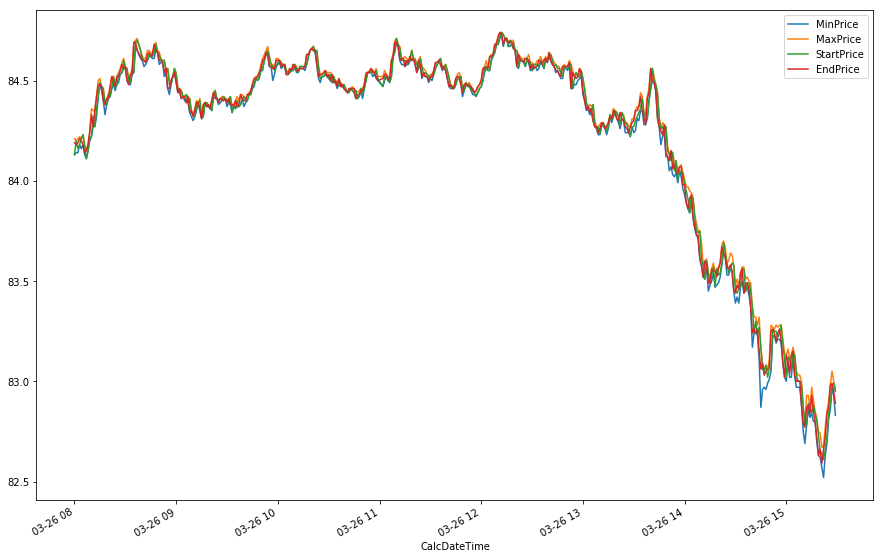

In [10]:
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs
def timeseries_plot(df, mnemonics, metrics):
    ax = None
    for mnemonic in mnemonics:
        for metric in metrics:
            selected = df[df.Mnemonic == mnemonic][['CalcDateTime', metric]].copy()
            selected.index = selected['CalcDateTime']
            del selected['CalcDateTime']
            ax = selected.plot( ax = ax)
    
timeseries_plot(cleaned_common_stock, ['SAP'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

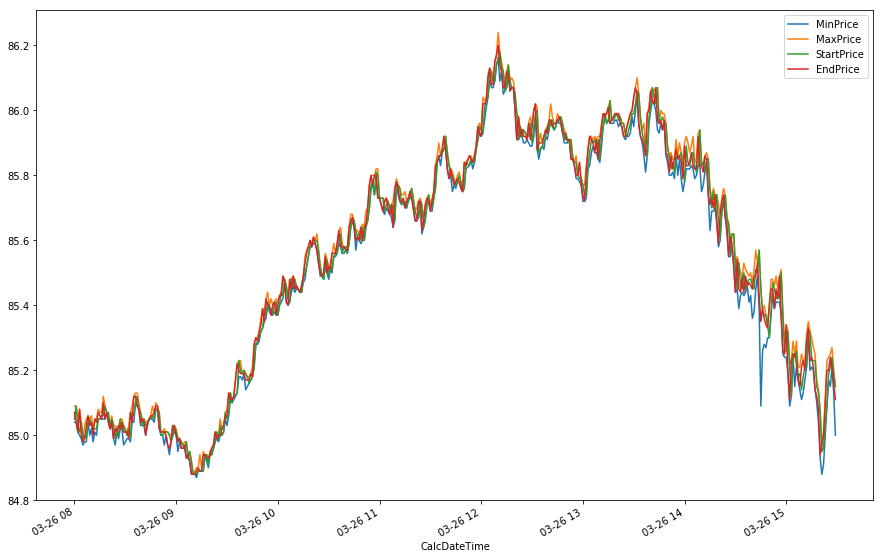

In [11]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

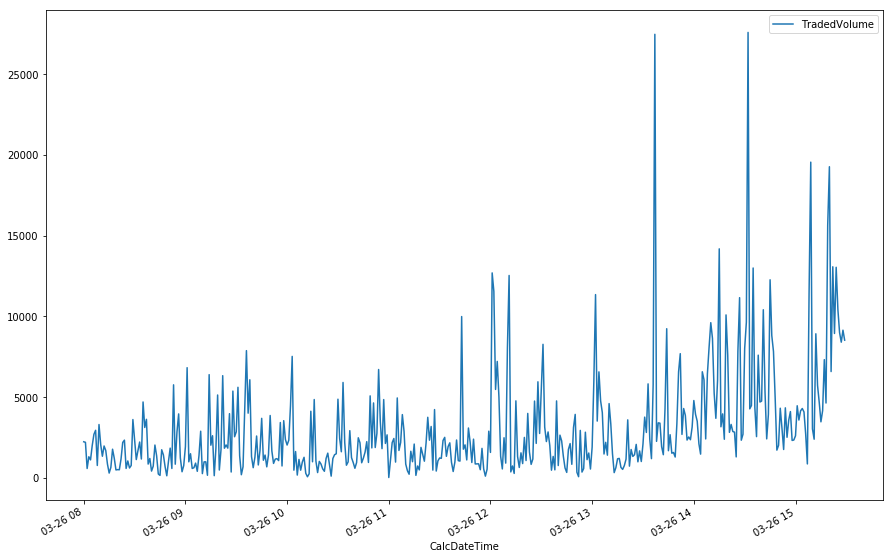

In [12]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['TradedVolume'])

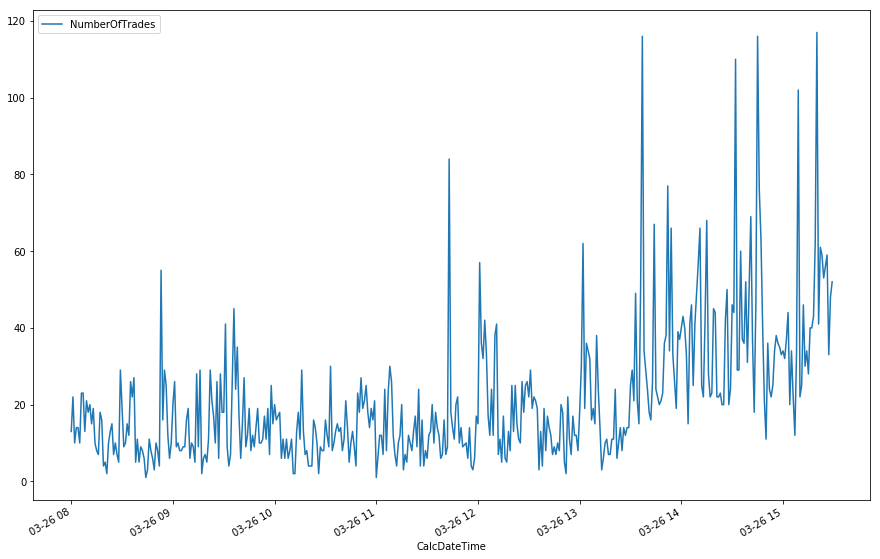

In [16]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['NumberOfTrades'])

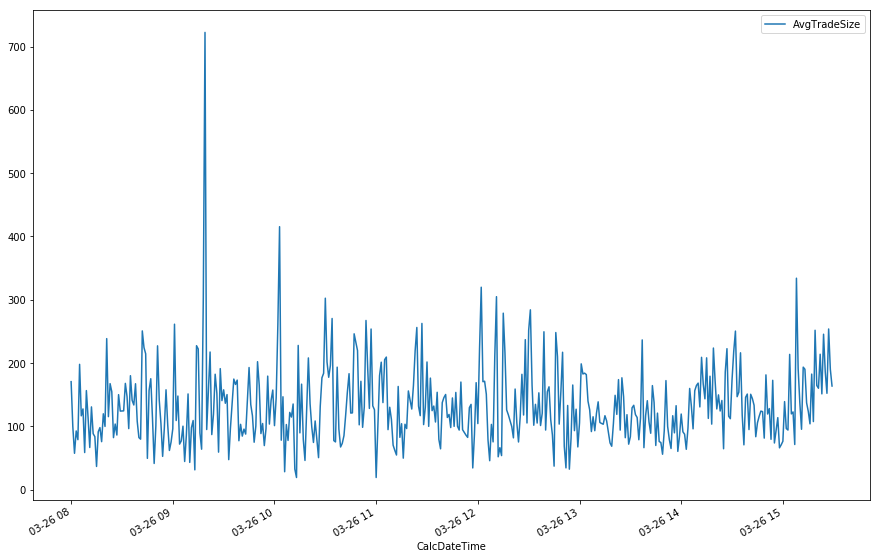

In [18]:
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected['AvgTradeSize'] = selected['TradedVolume'] / (0.1 + selected['NumberOfTrades'])
selected[['AvgTradeSize']].plot()

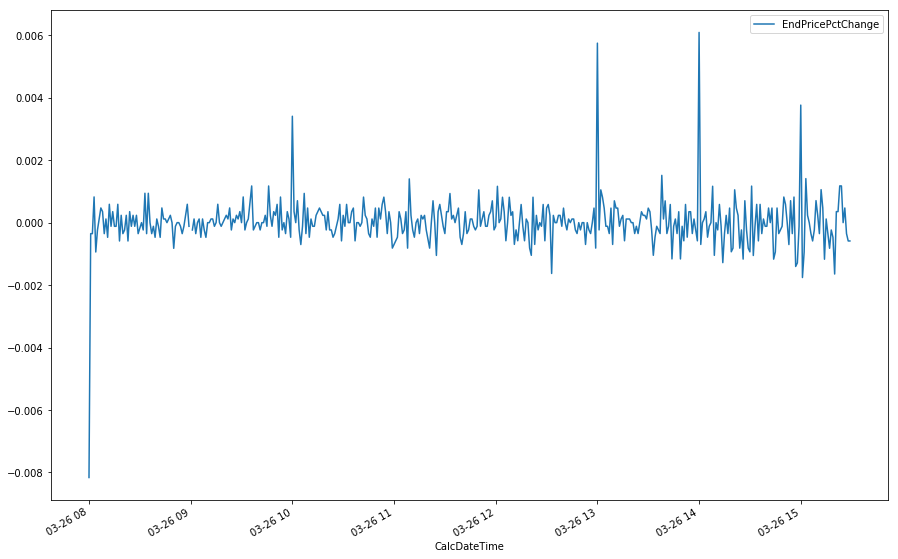

In [19]:
# Compute and plot pct change
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected['EndPricePctChange'] = selected['EndPrice'].pct_change()
selected[['EndPricePctChange']].plot()

## 4. Resampling the data into 15 minute intervals to observe trends

In order to illustrate some trends, we will resample the data into 15 minute intervals

In [143]:
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
interval = '15Min'
resampled = pd.DataFrame({
    'EndPrice': selected['EndPrice'].resample(interval).last(),
    'StartPrice': selected['StartPrice'].resample(interval).first(),    
    'MinPrice': selected['MinPrice'].resample(interval).min(),  
    'MaxPrice': selected['MaxPrice'].resample(interval).max(),   
})

### Observartion 1
As it can be observed from the graph below:
- when there is a downward trend, the `EndPrice` is closer to the `MinPrice`, than to the `MaxPrice`
- when there is an upward trend, the `EndPrice` is closer to `MaxPrice` than to the `MinPrice`

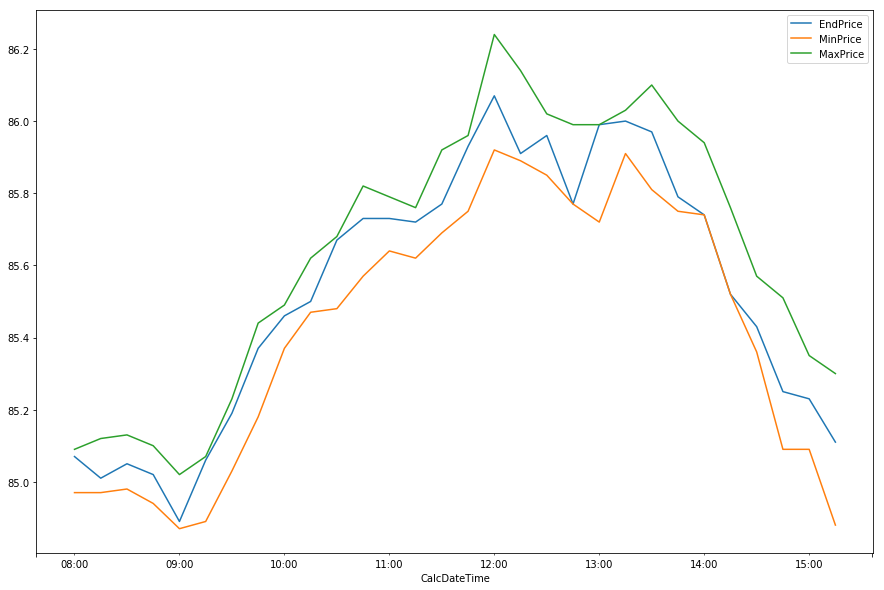

In [144]:
resampled[['EndPrice', 'MinPrice', 'MaxPrice']].plot()

### Observation 2
Similar (and correlated) behavior is true for the `StartPrice`

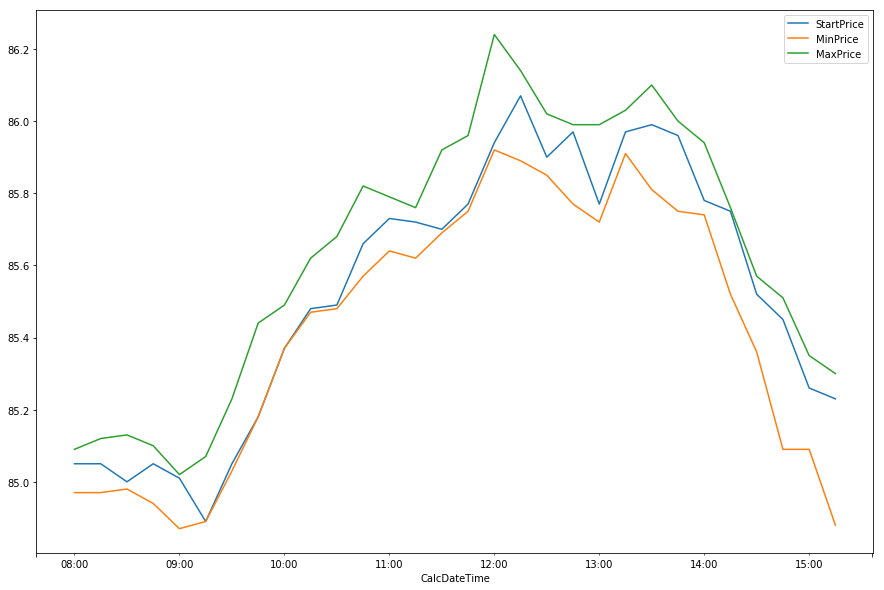

In [145]:
resampled[['StartPrice', 'MinPrice', 'MaxPrice']].plot()

### Observation 3

Another observation that can be made is that:

    - when the trend is upwards, `EndPrice` is above `StartPrice`
    - when the trend is downwars, `EndPrice` is below `StartPrice`
    
Therefore: if the lines of `EndPrice` and `StartPrice` cross, one could expect trend reversal.
(Of course one needs to account for the variance, and false positives)

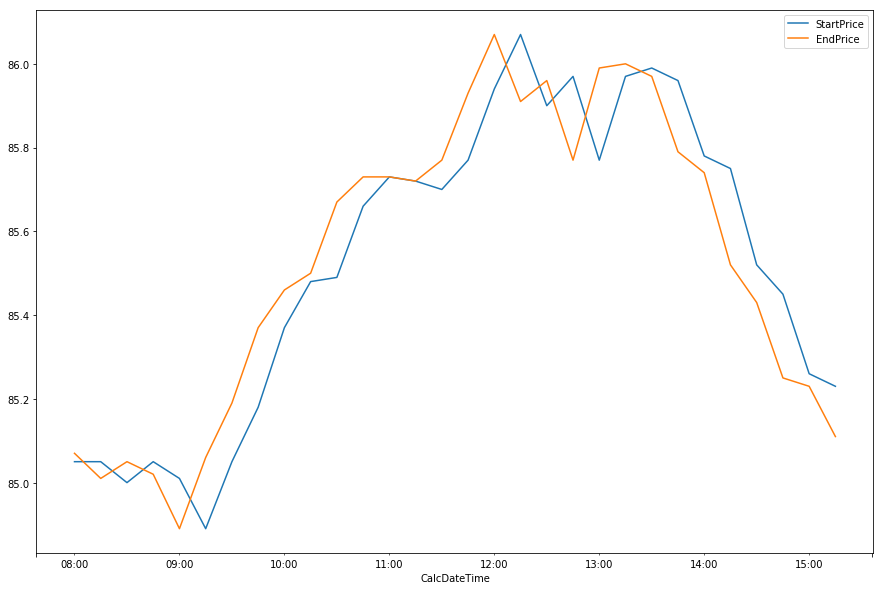

In [148]:
resampled[['StartPrice', 'EndPrice']].plot()

### Rate of return or percent change

Often times, when people model the stock market behavior, they are interested in the rates of return, or
how much do the price changes compared to the previous price.

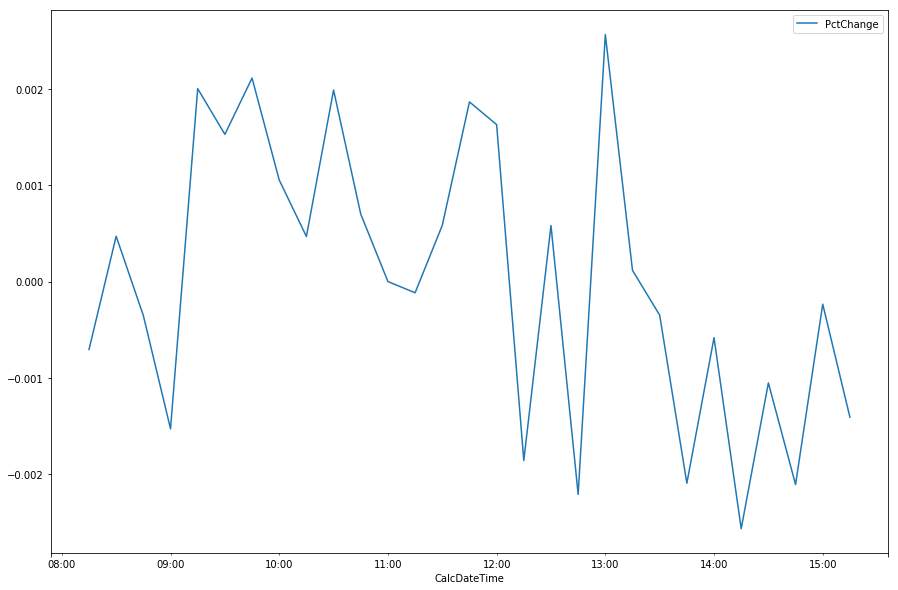

In [146]:
resampled['PctChange'] = resampled['EndPrice'].pct_change()
resampled[['PctChange']].plot()

### Correlation with Rate of Return

As a simple valiation of our observation from above regarding the relationship between prices and movements,
we can compute the correlation between an indicator and rate of return.
The indicator needs to be computed from the previos period.
This is what we did below. The interesting relationship is the correlation between `PctChange` and `Indicator[t - 1]`

In [154]:
def line_distance(df, a, b):
    return np.absolute(df[a] - df[b]) + np.absolute(df[a].shift(1) - df[b].shift(1))

distance_to_max_line = line_distance(resampled, 'MaxPrice', 'EndPrice')
distance_to_min_line = line_distance(resampled, 'MinPrice', 'EndPrice')

resampled['Indicator'] = (distance_to_min_line - distance_to_max_line)/100.0 # divide by 100 because the prices are around 100,
resampled['Indicator[t - 1]'] = resampled['Indicator'].shift(1)
resampled['PctChange[t - 1]'] = resampled['PctChange'].shift(1)

resampled[['PctChange',  'PctChange[t - 1]', 'Indicator', 'Indicator[t - 1]']].corr()[['PctChange']]

,PctChange
PctChange,1.000000
PctChange[t - 1],0.180227
Indicator,0.657189
Indicator[t - 1],0.327822


### Validation

We are not going to validate this finding further in this notebook, because our goal here was to build some intuition about the stock market.
Readers are encouraged to validate this finding using more data (more stocks and more days), as well as to explore:
- effect of interval resampling
- effect of correlation with next minute, next 15 minutes
- combine the three observations from above into a single indicator

## Next steps: Dense neural nets and convolutional neural nets

Observe that our indicator is a linear combination of features, which can be followed by a non-linear thresholding operation. Moreover, we have actually at 3 indicators as per the 3 observations. The distance we computed were computed between lines, but they could be computed between data points.
This is an ideal situation for a two-layer neural network with one hidden dense layer.
In the notebooks to follow we should that such indicators (or features) can be synthesized automatically

Another observation is that we can resample data into 1 minute, 2 minute, 15 minutes, etc.
For each type of resampling one can compute the same types of features. Indeed, such operations are common for convolutional neural networks 